In [31]:
import numpy as np

data_path = '/home/yigit/Documents/projects/irl_sfm/data/demonstrations/2_people_sources_sinks/1591484085.npy'
tracks = np.load(data_path, allow_pickle=True, encoding='latin1')
tracks = tracks[:-1]  # last two were not complete, discarding them
# tracks=tracks[range(0, len(tracks), 2)]
num_tracks = len(tracks)
print(num_tracks)

483


In [32]:
min_len = 1000
min_id = -1

for i in range(num_tracks):
    if len(tracks[i]) < min_len:
        min_len = len(tracks[i])
        min_id = i
        
print(f'{min_id}: {min_len}')

262: 306


##### Normalizing the lengths:
Uniformly selecting *desired_len* samples per track

In [33]:
desired_len = min_len
X, Y = np.zeros((num_tracks, desired_len, 8)), np.zeros((num_tracks, desired_len, 2))

for i in range(num_tracks):
    # normalizing the lengths
    len_track = len(tracks[i])
    indices = np.linspace(0, len_track-1, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    x, y = np.zeros((desired_len, 8)), np.zeros((desired_len, 2))
    for new_ind, old_ind in enumerate(indices):
        x[new_ind] = tracks[i][old_ind][:-2]
        y[new_ind] = tracks[i][old_ind][-2:]
    X[i] = x
    Y[i] = y

##### Visualization

[Text(0, 0.5, 'cos(angle)'), Text(0.5, 0, 'step')]

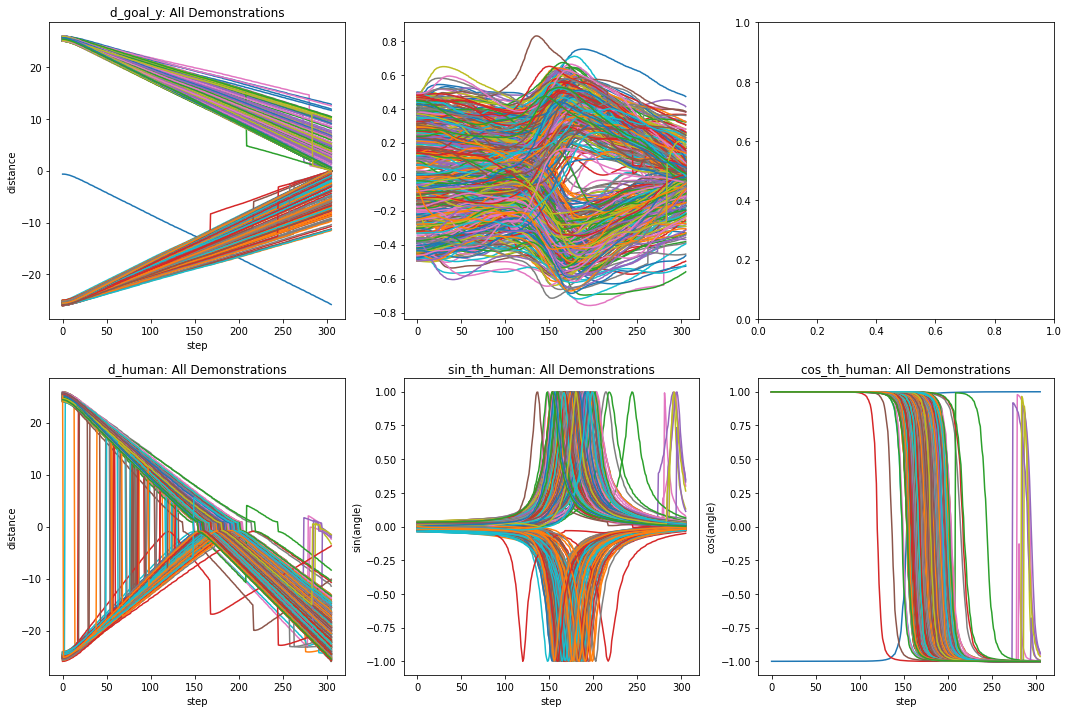

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 12]

fig, axs = plt.subplots(2, 3)
for i in range(num_tracks):
    axs[0, 0].plot(range(desired_len), X[i, :, 1])
axs[0, 0].set_title('d_goal_x: All Demonstrations')
axs[0, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[0, 1].plot(range(desired_len), X[i, :, 2])
axs[0, 0].set_title('d_goal_y: All Demonstrations')
axs[0, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[1, 0].plot(range(desired_len), X[i, :, 3])
axs[1, 0].set_title('d_human: All Demonstrations')
axs[1, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[1, 1].plot(range(desired_len), X[i, :, 4])
axs[1, 1].set_title('sin_th_human: All Demonstrations')
axs[1, 1].set(xlabel='step', ylabel='sin(angle)')

for i in range(num_tracks):
    axs[1, 2].plot(range(desired_len), X[i, :, 5])
axs[1, 2].set_title('cos_th_human: All Demonstrations')
axs[1, 2].set(xlabel='step', ylabel='cos(angle)')

# for ax in axs.flat:
#     ax.label_outer()

---
##### Some Cleanup

In [35]:
newX, newY = [], []
for i in range(num_tracks):
    keep = True
    for j in range(desired_len-1):
        if np.abs(X[i,j,1] - X[i,j+1,1]) > 3:  # jumps in d_g_x more than 3m
            print(i)
            keep = False
            break
        elif np.abs(X[i,j,3] - X[i,j+1,3]) > 3:  # jumps in d_h more than 3m
            print(f'{i}: {X[i,j,3]} - {X[i,j+1,3]}')
            keep = False
            break
        elif X[i,j,1] < 0:
            print(i)
            keep = False
            break
    if keep:
        newX.append(X[i])
        newY.append(Y[i])

num_tracks = len(newX)  # removed some tracks
X = np.array(newX)
Y = np.array(newY)
print(X.shape)
print(Y.shape)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
66
67
68: -22.003499822258235 - 0.7372121809423764
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
174
175
177
179
181
183
185
187
189
190
191
193
195
196: -23.225123305310586 - 2.083280053231509
197
199
201
203
205
207
209
211
213
215
217
219
221
223
225
227
229
231
233
234
235
237
239
241
243
245
247
249
251
252
253
255
257
259
261
263
265
267
269
271
273
275
277
279
281
283
285
287
289
291
293
295
297
299
301
303
305
307
309
311
313
315
317
319
321
323
325
327
329
331
333
335
337
339
341
343
345
347
349
351
353
355
357
359
361
363
365
367
369
371
373
375
377
379
381
383
385
387
389
391
393
395
397
399
401
403
405
407
409
411
413
415
417
419
421
423
425
427
429
431
433
435
437
439
441
443
444
445
447
449
451
453
455
457
459
461
463
465
467
469
47

[Text(0, 0.5, 'cos(angle)'), Text(0.5, 0, 'step')]

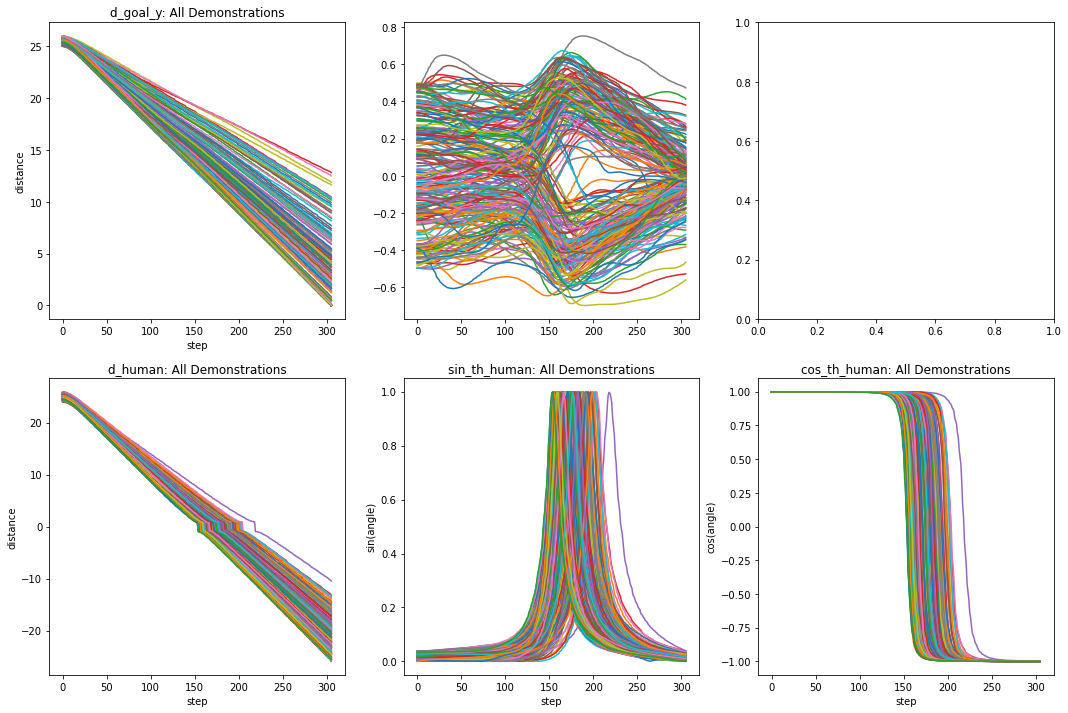

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 12]

fig, axs = plt.subplots(2, 3)
for i in range(num_tracks):
    axs[0, 0].plot(range(desired_len), X[i, :, 1])
axs[0, 0].set_title('d_goal_x: All Demonstrations')
axs[0, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[0, 1].plot(range(desired_len), X[i, :, 2])
axs[0, 0].set_title('d_goal_y: All Demonstrations')
axs[0, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[1, 0].plot(range(desired_len), X[i, :, 3])
axs[1, 0].set_title('d_human: All Demonstrations')
axs[1, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[1, 1].plot(range(desired_len), X[i, :, 4])
axs[1, 1].set_title('sin_th_human: All Demonstrations')
axs[1, 1].set(xlabel='step', ylabel='sin(angle)')

for i in range(num_tracks):
    axs[1, 2].plot(range(desired_len), X[i, :, 5])
axs[1, 2].set_title('cos_th_human: All Demonstrations')
axs[1, 2].set(xlabel='step', ylabel='cos(angle)')

# for ax in axs.flat:
#     ax.label_outer()

---

In [37]:
from sklearn.model_selection import train_test_split

data_path = '/home/yigit/phd/yigit_phd_thesis/cnmp/data/2_people_sources_sinks/'

x_get_dims = np.array([1,2,3,4,5]) # other dims seem unnecessary
X = X[:, :, x_get_dims]

# reshaping to meet CNMP requirements
X = np.reshape(X, (num_tracks, desired_len, len(x_get_dims)))
Y = np.reshape(Y, (num_tracks, desired_len, 2))

# saving 20% for validation and the 80% for training
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

x_dims, gamma_dims = np.array([0, 1]), np.array([2, 3, 4])
x_train, gamma_train = x_train[:, :, x_dims], x_train[:, :, gamma_dims]  # human-related values go into gamma
x_val, gamma_val = x_val[:, :, x_dims], x_val[:, :, gamma_dims]

np.save(data_path+'d_x.npy', np.array(x_train))
np.save(data_path+'d_y.npy', np.array(y_train))
np.save(data_path+'d_gamma.npy', np.array(gamma_train))
np.save(data_path+'v_d_x.npy', np.array(x_val))
np.save(data_path+'v_d_y.npy', np.array(y_val))
np.save(data_path+'v_d_gamma.npy', np.array(gamma_val))